In [16]:
import os

dataset_path = '/kaggle/input/bird-speciees-dataset/Bird Speciees Dataset'

print("Dataset folders:")
species_folders = os.listdir(dataset_path)
print(f"Found {len(species_folders)} species folders")

# Count total images across all folders
total_images = 0
for folder in species_folders:
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):  # Make sure it's actually a folder
        image_count = len(os.listdir(folder_path))
        total_images += image_count
        print(f"{folder}: {image_count} images")

bird_data = {
    'path': dataset_path,
    'species': species_folders,
    'total_species': len(species_folders),
    'total_images': total_images  # Add this line
}

print(f"\nData ready! Total species: {bird_data['total_species']}")
print(f"Total images across all folders: {total_images}")  # Add this line


Dataset folders:
Found 6 species folders
CARMINE BEE-EATER: 131 images
AMERICAN GOLDFINCH: 143 images
DOWNY WOODPECKER: 137 images
EMPEROR PENGUIN: 139 images
BARN OWL: 129 images
FLAMINGO: 132 images

Data ready! Total species: 6
Total images across all folders: 811


In [17]:

nonbird_dataset_path = '/kaggle/input/image-dataset/train2014'

print("Non-bird Dataset folders:")
if os.path.exists(nonbird_dataset_path):
    all_files = os.listdir(nonbird_dataset_path)
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    image_files = [f for f in all_files if any(f.lower().endswith(ext) for ext in image_extensions)]
   
    total_nonbird_images = len(image_files)
    print(f"Found {total_nonbird_images} image files")
else:
    total_nonbird_images = 0
    print("Dataset path not found")

combined_nonbird_data = {
    'paths': [nonbird_dataset_path],
    'all_categories': ['non-bird'], 
    'total_categories': 1,
    'total_images': total_nonbird_images
}

print(f"\nData ready! Total categories: {combined_nonbird_data['total_categories']}")
print(f"Total images: {total_nonbird_images}")

Non-bird Dataset folders:
Found 82783 image files

Data ready! Total categories: 1
Total images: 82783


In [18]:
classification_data = {
    'bird': bird_data,
    'not_bird': combined_nonbird_data,
    'classes': ['bird', 'not_bird']
}

print(f"Final setup:")
print(f"- Bird species: {classification_data['bird']['total_species']}")
print(f"- Non-bird categories: {classification_data['not_bird']['total_categories']}")
print(f"- Total classes: {len(classification_data['classes'])}")

Final setup:
- Bird species: 6
- Non-bird categories: 1
- Total classes: 2


In [19]:
def create_binary_dataset():
    bird_images = []
    not_bird_images = []
   
    bird_base_path = '/kaggle/input/bird-speciees-dataset/Bird Speciees Dataset'
    for species_folder in os.listdir(bird_base_path):
        species_path = os.path.join(bird_base_path, species_folder)
        if os.path.isdir(species_path):
            for image_file in os.listdir(species_path):
                if image_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    bird_images.append(os.path.join(species_path, image_file))
   
    nonbird_base_path = '/kaggle/input/image-dataset/train2014'
    if os.path.exists(nonbird_base_path):
        for image_file in os.listdir(nonbird_base_path):
            if image_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                not_bird_images.append(os.path.join(nonbird_base_path, image_file))
   
    return bird_images, not_bird_images

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' 

from PIL import Image

#model = tf.keras.Sequential([
    # Your existing layers...
   # tf.keras.layers.Dense(2, activation='softmax')  # Changed from 22 to 2
#])

# Or even simpler binary classification:
# tf.keras.layers.Dense(1, activation='sigmoid')

In [21]:
bird_images, not_bird_images = create_binary_dataset()

print(f"Found {len(bird_images)} bird images")
print(f"Found {len(not_bird_images)} non-bird images")
print(f"Total images: {len(bird_images) + len(not_bird_images)}")

Found 811 bird images
Found 82783 non-bird images
Total images: 83594


In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [23]:
def load_images_with_labels(bird_images, not_bird_images, img_size=(224, 224), max_per_class=800):
    """Load images and create labels for training"""
   
    all_images = []
    all_labels = []
   
    print("Loading bird images...")
    count = 0
    
    for img_path in bird_images[:max_per_class]:
        try:
            img = Image.open(img_path).resize(img_size)

            if img.mode != 'RGB':
                img = img.convert('RGB')
            all_images.append(np.array(img))
            all_labels.append(1)  # Bird = 1
            count += 1
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
   
    print(f"Loaded {count} bird images")
   
    print("Loading non-bird images...")
    count2 = 0
    
    for img_path in not_bird_images[:max_per_class]:
        try:
            img = Image.open(img_path).resize(img_size)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            all_images.append(np.array(img))
            all_labels.append(0)  
            count2 += 1
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
   
    print(f"Loaded {count2} non-bird images")
    print(f"Total images loaded: {len(all_images)}")
   
    return np.array(all_images), np.array(all_labels)

print("Loading images...")
X, y = load_images_with_labels(bird_images, not_bird_images)

Loading images...
Loading bird images...
Loaded 800 bird images
Loading non-bird images...
Loaded 800 non-bird images
Total images loaded: 1600


In [24]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(X, y, epochs=25, validation_split=0.2)


Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 489ms/step - accuracy: 0.5805 - loss: 3.9208 - val_accuracy: 0.0000e+00 - val_loss: 0.7612
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 454ms/step - accuracy: 0.5937 - loss: 0.6688 - val_accuracy: 0.0000e+00 - val_loss: 0.9458
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 467ms/step - accuracy: 0.6090 - loss: 0.6457 - val_accuracy: 0.0000e+00 - val_loss: 0.9730
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step - accuracy: 0.6328 - loss: 0.6386 - val_accuracy: 0.3750 - val_loss: 0.7880
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step - accuracy: 0.6956 - loss: 0.5818 - val_accuracy: 0.1094 - val_loss: 0.8467
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 465ms/step - accuracy: 0.6803 - loss: 0.5908 - val_accuracy: 0.4625 - val_loss: 0.7963
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 467ms/step - accuracy: 0.7346 - loss: 0.5284 - val_accuracy: 0.4875 - val_loss: 0.7338
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 462ms/step - accuracy: 0.7163 - loss: 0.513

In [28]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
from pathlib import Path
import shutil

class ValidationSetUploader:
    def __init__(self):
        self.validation_path = Path('/kaggle/working/validation-set')
        self.validation_path.mkdir(parents=True, exist_ok=True)
        
        self.upload_widget = widgets.FileUpload(
            accept='.jpg,.jpeg,.png,.bmp,.tiff,.webp',
            multiple=True,
            description='Drop Images Here:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(
                width='500px', 
                height='150px',
                border='3px dashed #007acc',
                padding='20px',
                margin='10px'
            )
        )
        
        self.output = widgets.Output()
        
        self.upload_widget.observe(self._handle_upload, names='value')
        
    def _handle_upload(self, change):
        with self.output:
            clear_output()
            if self.upload_widget.value:
                print(" Uploading files to validation-set directory...")
            
                for file_info in self.upload_widget.value:
                    file_path = self.validation_path / file_info.name
                    with open(file_path, 'wb') as f:
                        f.write(file_info.content)
                    print(f" Saved: {file_info.name}")
            
                self.upload_widget.value = ()
            
                total_files = len(list(self.validation_path.glob('*')))
                print(f" Total files in validation-set: {total_files}")
            
    def display(self):
        existing_files = list(self.validation_path.glob('*'))
        print(f" Validation Set Directory: {self.validation_path}")
        print(f" Current files: {len(existing_files)}")
        
        display(self.upload_widget)
        display(self.output)

validation_uploader = ValidationSetUploader()
validation_uploader.display()

📂 Validation Set Directory: /kaggle/working/validation-set
📊 Current files: 1


FileUpload(value=(), accept='.jpg,.jpeg,.png,.bmp,.tiff,.webp', description='Drop Images Here:', layout=Layout…

Output()

📁 Found 1 files
🎯 Select an image from existing files:


Dropdown(description='Select file:', layout=Layout(width='400px'), options=(('IMG_0093.jpeg', '/kaggle/working…

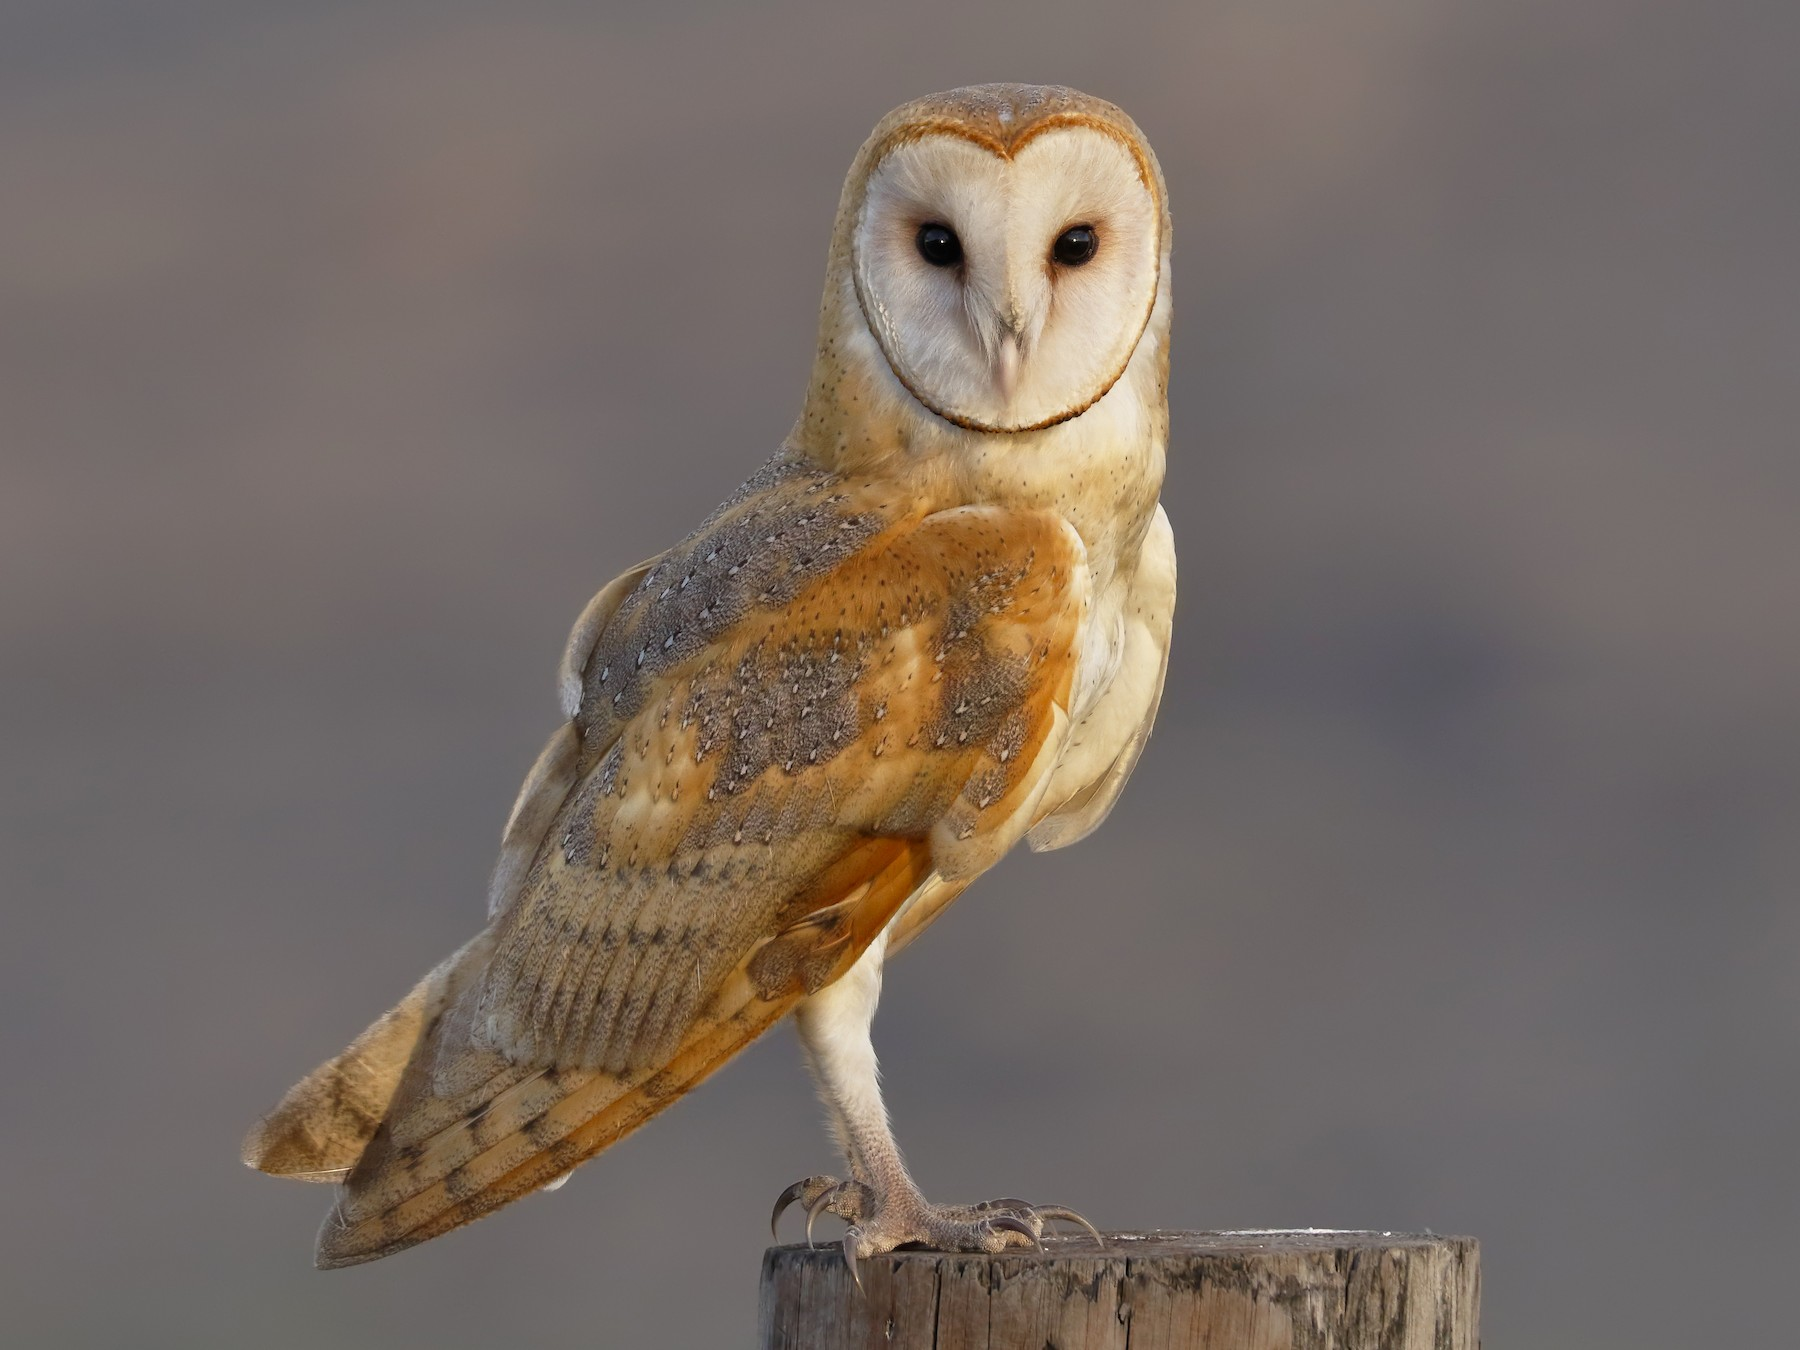

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_refresh_dropdown', 'file_dropdown', 'get_selected_image', 'test_data_path']


In [29]:
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, Image, HTML

class PhotoSelector:
    def __init__(self):
        self.file_dropdown = None
        self.test_data_path = Path('/kaggle/working/validation-set')
        self.test_data_path.mkdir(parents=True, exist_ok=True)

    def get_selected_image(self):
        if self.file_dropdown is None or self.file_dropdown.value is None:
            return None, None
        
        image_path = self.file_dropdown.value
        image_name = Path(image_path).name
        return image_path, image_name

    def _refresh_dropdown(self):
        files = [f for f in self.test_data_path.rglob('*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']]
        if files:
            file_options = [(f.name, str(f)) for f in files]
            self.file_dropdown.options = file_options
            print(f"Updated: Found {len(files)} files")
        else:
            self.file_dropdown.options = []
            print("No image files found")

def browse_local_dataset():
    def show_image(change):
        if change.new:
            display(Image(change.new, width=300))

    try:
        dataset_path = Path('/kaggle/working/validation-set')
        dataset_path.mkdir(parents=True, exist_ok=True)
        
        files = [f for f in dataset_path.rglob('*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']]
        
        print(f"Found {len(files)} files")
        
        file_options = [(f.name, str(f)) for f in files] if files else []
        
        global photo_selector
        photo_selector = PhotoSelector()
        
        photo_selector.file_dropdown = widgets.Dropdown(
            options=file_options,
            description='Select file:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='400px')
        )
        
        photo_selector.file_dropdown.observe(show_image, names='value')
        
        print("Select an image from existing files:")
        display(photo_selector.file_dropdown)
        
        if photo_selector.file_dropdown.value:
            display(Image(photo_selector.file_dropdown.value, width=300))

    except Exception as e:
        print(f"Error: {e}")

# Call the function
browse_local_dataset()
print(dir(photo_selector))

In [30]:
def preprocess_image_for_prediction(image_path):
    """Preprocess an image for prediction"""
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))  # or whatever size you used
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = img_array / 255.0
    return img_array

def classify_selected_image():
    if 'photo_selector' not in globals():
        print("Please run the photo selection cell first!")
        return
    
    selected_image_path, selected_title = photo_selector.get_selected_image()
    if selected_image_path is None:
        print("No image selected!")
        return
    
    processed_image = preprocess_image_for_prediction(selected_image_path)
    
    prediction = model.predict(processed_image)
    
    is_bird = prediction[0][1] > 0.3
    confidence = max(prediction[0])
    
    print(f"Image: {selected_title}")
    print(f"Result: {'Bird' if is_bird else 'Not Bird'}")
    print(f"Confidence: {confidence:.1%}")
    
    return {
        'is_bird': is_bird,
        'confidence': confidence,
        'raw_prediction': prediction[0]
    }

classify_selected_image()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
🖼️ Image: IMG_0093.jpeg
🐦 Result: Not Bird
📊 Confidence: 91.8%


{'is_bird': False,
 'confidence': 0.9177558,
 'raw_prediction': array([0.9177558 , 0.08224427], dtype=float32)}